This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

In [1]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [2]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on CPU 
///////////////


In [3]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [57]:
#Geometry and residual
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
nu = 1
c = 1

def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=0)

    # Backend pytorch
    return (
        dy_t
        + c*dy_x
        - nu*dy_xx
        
        )

In [58]:
#Conditions (Boudary & Initial)
def IC_func(x):
    return -np.sin(np.pi * x[:, 0:1])

def BC_func(x):
    return 0


ic = dde.icbc.IC(geomtime, IC_func, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, BC_func, lambda _, on_boundary: on_boundary)


In [59]:
#Data and model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    num_test=10000,
)


layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

Compiling model...
'compile' took 0.000323 s

Training model...

Step      Train loss                        Test loss                         Test metric
12463     [1.10e-03, 4.67e-05, 5.56e-05]    [1.17e-01, 4.67e-05, 5.56e-05]    []  
13000     [8.97e-06, 1.88e-05, 4.23e-05]    [1.17e-01, 1.88e-05, 4.23e-05]    []  
14000     [9.26e-06, 1.75e-05, 3.42e-05]    [1.16e-01, 1.75e-05, 3.42e-05]    []  
15000     [7.94e-06, 1.61e-05, 2.87e-05]    [1.16e-01, 1.61e-05, 2.87e-05]    []  
16000     [1.50e-04, 1.91e-05, 2.69e-05]    [1.14e-01, 1.91e-05, 2.69e-05]    []  
17000     [6.03e-06, 1.44e-05, 2.10e-05]    [1.13e-01, 1.44e-05, 2.10e-05]    []  
18000     [1.21e-04, 1.57e-05, 1.99e-05]    [1.11e-01, 1.57e-05, 1.99e-05]    []  
19000     [1.66e-04, 1.79e-05, 1.67e-05]    [1.10e-01, 1.79e-05, 1.67e-05]    []  
20000     [6.33e-06, 1.28e-05, 1.42e-05]    [1.08e-01, 1.28e-05, 1.42e-05]    []  
21000     [1.53e-05, 1.27e-05, 1.27e-05]    [1.07e-01, 1.27e-05, 1.27e-05]    []  
22000     [5.80

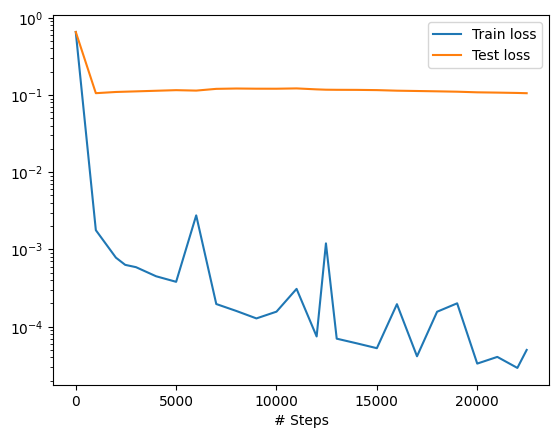

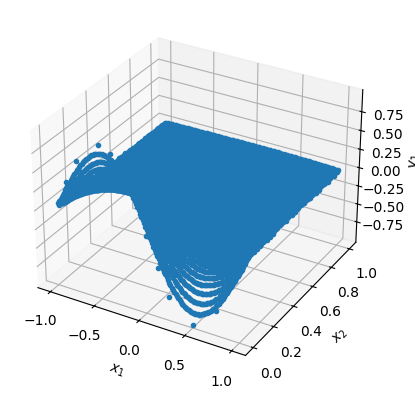

In [62]:
#Computations and graph
model.compile("adam", lr=0.001)
# model.compile("adam", lr=0.0001, loss_weights=[1, 1, 1000])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)



In [80]:
def analytical_sol(x, t, N, C=c, v=nu):
    sum_sinh = 0
    sum_cosh = 0
    
    for p in range(N+1): 
        some_term = (C**4 + 8*(C*np.pi*v)*(p**2+1)+16*(np.pi*v)**4*(p**2-1)**2)
        term_sinh = (-1)**p*(2*p * np.sin(p*np.pi*x)) * np.exp(-v*p**2*np.pi**2*t)/some_term
        sum_sinh += term_sinh
        
        some_term = (C**4+ (C*np.pi*v)**2*(8*p**2 + 8*p + 10) + (np.pi*v)**4*(4*p**2+4*p-3)**2)
        term_cosh = (-1)**p*(2*p + 1) * np.cos((2*p+1)/2*np.pi*x)* np.exp(-v*(2*p+1)**2/4*np.pi**2*t)/some_term

        sum_cosh += term_cosh
    
    u_xt = 16*np.pi**2*v**3*C * np.exp(C/(2*v)*(x-C/2*t)) * (np.sinh(C/(2*v)) * sum_sinh + np.cosh(C/(2*v)) * sum_cosh)
    
    return u_xt


def analytical_sol_approx(x, t,N=200):
    S = np.sum(np.array([  (-1)**p*(2*p*np.sin(p*np.pi*x) + (2*p+1)*np.cos((2*p+1)/2*np.pi*x) ) for p in range(N+1)]  ))
    return 8*np.pi**2*(nu/c)**3*np.exp((c/(2*nu))*(x+1 - c/2*t)) * S


def analytical_sol_approx_2(x, t):
    return (c*t < x+1)*-np.sin(np.pi*(x-c*t))*(1-nu*np.pi**2*(x-1))


1584.678197772757
51.26548245743669
14153.572815039939
99999.23663110565
351100.9843232969
898376.6342413129
1910149.09569191
3592146.3689389005
6187501.545203156
9976752.806662602
15277843.426452223
22446121.768664062
31874341.28834721
43992660.53150783
59268643.13510913
78207257.82707138
101350878.4262719
129279283.84254508
162609658.07668233
201996590.22043222
248132074.45650023
301745510.058549
363603701.39119816
434510857.91002446
515308594.1615618
606875929.7833008
710129289.5036894
826022503.1421328
955546805.6089927
1099730836.9055882
1259640642.1241956
1436379671.448048
1631088780.1513355
1844946228.599206


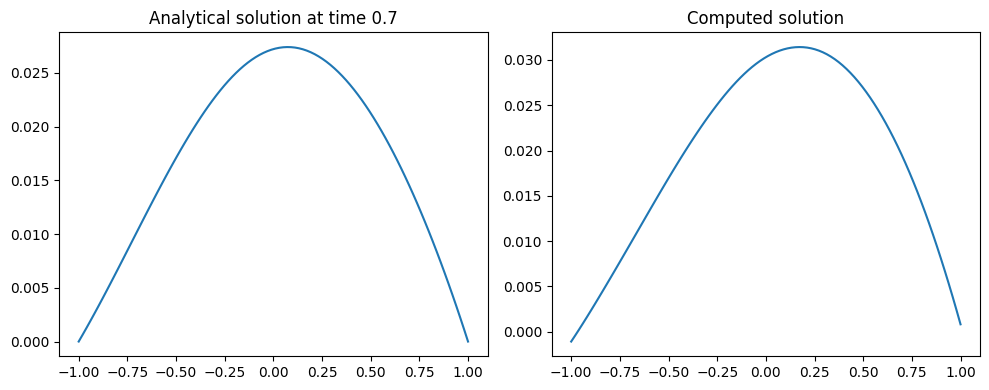

In [81]:
# Define the time t_1 at which you want to display the function
t_1 = 0.7

# Define the spatial domain where you want to evaluate the function
x = np.linspace(-1, 1, 100)

# Evaluate the function u(x, t) at the specified time t_1 and spatial domain x
u_x_t1 = model.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)]))) #Makes a vertical 2d vector

#analytical solution
a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N= 33)



# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot something on the first subplot
axs[0].plot(x, a_x_t1)
axs[0].set_title('Analytical solution at time {}'.format(t_1))

# Plot something on the second subplot
axs[1].plot(x, u_x_t1)
axs[1].set_title('Computed solution')

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plots
plt.show()

1584.678197772757
51.26548245743669
14153.572815039939
99999.23663110565
351100.9843232969
898376.6342413129
1910149.09569191
3592146.3689389005
6187501.545203156
9976752.806662602
15277843.426452223
22446121.768664062
31874341.28834721
43992660.53150783
59268643.13510913
78207257.82707138
101350878.4262719
129279283.84254508
162609658.07668233
201996590.22043222
248132074.45650023
301745510.058549
363603701.39119816
434510857.91002446
515308594.1615618
606875929.7833008
710129289.5036894
826022503.1421328
955546805.6089927
1099730836.9055882
1259640642.1241956
1436379671.448048
1631088780.1513355
1844946228.599206
2079167682.2477627
2335006211.6440682
2613752292.4261403
2916733805.3229547
3245316036.1544437
3600901675.831497
3984930820.355962
4398880970.820641
4844267033.409297
5322641319.396646
5835593545.148363
6384750832.12108
6971777706.862388
7598376101.010831
8266285351.295914
8977282199.538094
9733180792.64879
10535832682.630379
11387126826.576187
12288989586.670507
13243384730

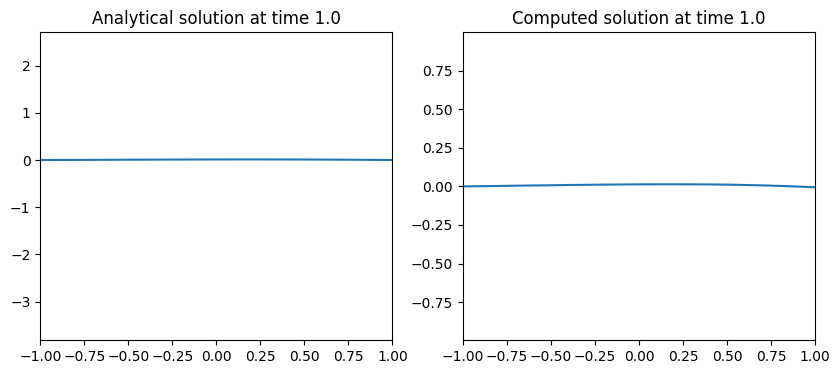

In [87]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Order = 5000
# Define the time domain
t = np.linspace(0, 1, 30)


# Initialize the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

u_x_t1 = model.predict(np.transpose(np.vstack([x, 0*np.ones_like(x)])))
a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)

# Initialize the lines to be updated in the animation
line_analytical, = axs[0].plot([], [], label='Analytical solution')
line_computed, = axs[1].plot([], [], label='Computed solution')
axs[0].set_xlim([-1, 1])
axs[1].set_xlim([-1, 1])

axs[0].set_ylim([a_x_t1.min(), a_x_t1.max()])
axs[1].set_ylim([u_x_t1.min(), u_x_t1.max()])

# Update function for the animation
def update(frame):
    t_1 = t[frame]
    u_x_t1 = model.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)])))
    a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N=Order)
    
    line_analytical.set_data(x, a_x_t1)
    line_computed.set_data(x, u_x_t1)
    
    axs[0].set_title('Analytical solution at time {}'.format(t_1))
    axs[1].set_title('Computed solution at time {}'.format(t_1))
    
    return line_analytical, line_computed

# Create the animation
animation = FuncAnimation(fig, update, frames=len(t), blit=True)

# Show the animation
HTML(animation.to_jshtml())
